<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_7/capstone/RD/7_1d_Lyric_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lyric NLP
### Table of Contents
- Import Data
- Clustering
  - K-Means
  - Mean Shift
  - Spectral Clustering
  - Affinity Propagation
  - Agglomerative Clustering
  - DBSCAN
- Supervised Modeling
  - Naive Bayes
  - Support Vector Machine
  - SGD Classifier
  - Multilayer Perceptron
  - Random Forest
  - Gradient Boosting
- Model Tuning
- Final Model
- Conclusion

## Import Data

In [0]:
# load packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import silhouette_score, adjusted_rand_score

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [0]:
#from google.colab import files
#files.upload()

In [3]:
filename = "spotify_test_data"
df_af = pd.read_csv(filename + ".csv", index_col=0)

df_af.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,target,tempo,time_signature,track_href,type,uri,valence,track_names,artist_names,album_names,release_dates,popularity,explicit
0,0.1730,https://api.spotify.com/v1/audio-analysis/7eEl...,0.796,197236,0.467,7eElVgPcxDqmgGrSwVFI74,0.004110,6,0.1260,-10.369,1,0.1810,1,107.901,4,https://api.spotify.com/v1/tracks/7eElVgPcxDqm...,audio_features,spotify:track:7eElVgPcxDqmgGrSwVFI74,0.516,Sober,Lorde,Melodrama,2017-06-16,59,True
1,0.2870,https://api.spotify.com/v1/audio-analysis/02oA...,0.771,189796,0.431,02oAUzv4M0ItuTDy2RT3IT,0.000003,10,0.0934,-5.423,1,0.0577,1,107.047,4,https://api.spotify.com/v1/tracks/02oAUzv4M0It...,audio_features,spotify:track:02oAUzv4M0ItuTDy2RT3IT,0.268,Homemade Dynamite,Lorde,Melodrama,2017-06-16,60,True
2,0.2390,https://api.spotify.com/v1/audio-analysis/5q4B...,0.664,271088,0.382,5q4BpnMrYEFzLO0dYODj6J,0.007490,0,0.0943,-9.977,1,0.0470,1,123.214,4,https://api.spotify.com/v1/tracks/5q4BpnMrYEFz...,audio_features,spotify:track:5q4BpnMrYEFzLO0dYODj6J,0.126,The Louvre,Lorde,Melodrama,2017-06-16,61,False
3,0.9200,https://api.spotify.com/v1/audio-analysis/6Kkt...,0.587,171728,0.229,6Kkt27YmFyIFrcX3QXFi2o,0.000000,10,0.1000,-11.254,0,0.1280,1,75.670,4,https://api.spotify.com/v1/tracks/6Kkt27YmFyIF...,audio_features,spotify:track:6Kkt27YmFyIFrcX3QXFi2o,0.379,Liability,Lorde,Melodrama,2017-06-16,69,False
4,0.0328,https://api.spotify.com/v1/audio-analysis/1Dp7...,0.487,367391,0.445,1Dp7JGFNjvg8Nk0CtMCcnr,0.010400,1,0.0778,-10.959,0,0.1130,1,97.031,4,https://api.spotify.com/v1/tracks/1Dp7JGFNjvg8...,audio_features,spotify:track:1Dp7JGFNjvg8Nk0CtMCcnr,0.180,Hard Feelings/Loveless,Lorde,Melodrama,2017-06-16,60,True


In [4]:
# change field size to avoid ParseError
import sys
import csv

csv.field_size_limit(sys.maxsize)

filename = "lyric_test_data_parsed"
# set engine="python" to avoid ParseError
# set error_bad_lines=False
#df_lyrics = pd.read_csv(filename + ".csv", index_col=0,
#                        engine="python", error_bad_lines=False)
df_lyrics = pd.read_csv(filename + ".csv", index_col=0)
# make sure lyric data is type string
#df_lyrics['lyrics_raw'] = df_lyrics['lyrics_raw'].astype(str)
#df_lyrics['lyrics_clean'] = df_lyrics['lyrics_clean'].astype(str)
df_lyrics.head()

,id,lyrics_raw,length_raw,lyrics_clean,length_clean,lyrics_parsed,length_parsed,lyrics_nostops,length_nostops
0,7eElVgPcxDqmgGrSwVFI74,"[Intro]\nNight, midnight, lose my mind\nNight,...",2485.0,night midnight lose my mind night midnight lo...,2275.0,"[' ', 'night', 'midnight', 'lose', '-PRON-', '...",494,"[' ', 'night', 'midnight', 'lose', 'mind', 'ni...",187
1,02oAUzv4M0ItuTDy2RT3IT,[Verse 1]\nA couple rebel top gun pilots\nFlyi...,1795.0,couple rebel top gun pilots flying with nowhe...,1621.0,"[' ', 'couple', 'rebel', 'top', 'gun', 'pilot'...",309,"[' ', 'couple', 'rebel', 'gun', 'pilot', 'fly'...",169
2,5q4BpnMrYEFzLO0dYODj6J,"[Verse 1]\nWell, summer slipped us underneath ...",1824.0,well summer slipped us underneath her tongue ...,1665.0,"[' ', 'well', 'summer', 'slip', '-PRON-', 'und...",334,"[' ', 'summer', 'slip', 'underneath', 'tongue'...",151
3,6Kkt27YmFyIFrcX3QXFi2o,"[Intro]\nOne, two\n\n[Verse 1]\nBaby really hu...",1305.0,one two baby really hurt me crying in the tax...,1157.0,"[' ', 'one', 'two', 'baby', 'really', 'hurt', ...",242,"[' ', 'baby', 'hurt', 'cry', 'taxi', 'don', 'w...",101
4,1Dp7JGFNjvg8Nk0CtMCcnr,Hard Feelings\n\n(Go back and tell it)\n\nPlea...,2386.0,hard feelings go back and tell it please could...,2189.0,"['hard', 'feeling', 'go', 'back', 'and', 'tell...",458,"['hard', 'feeling', 'tell', 'tender', 'sit', '...",244


In [5]:
filename = 'lyric_word_counts'
word_counts = pd.read_csv(filename+".csv", index_col=0)
word_counts.head()

,id,m,oh,know,don,love,like,will,get,go,nan,come,let,time,ve,feel,want,to,cause,wanna,yeah,heart,think,tell,,way,need,away,win,pre,right,fall,night,baby,leave,run,ain,hold,good,look,...,tear,ground,road,-PRON-,catch,gold,black,call,town,people,ghost,post,matter,big,well,better,touch,body,shine,ask,slow,round,sweet,kid,white,easy,feeling,blow,waste,money,pain,sound,keep,help,chase,city,fine,morning,sing,drop
0,7eElVgPcxDqmgGrSwVFI74,3,4,6,3,0,1,3,0,1,0,0,2,1,0,3,0,0,0,0,0,1,0,0,1,0,0,0,0,2,0,0,4,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
1,02oAUzv4M0ItuTDy2RT3IT,0,0,4,1,2,0,4,0,1,0,3,6,0,0,0,0,1,0,0,1,0,3,3,1,0,0,0,0,2,3,0,0,0,0,0,0,0,6,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0
2,5q4BpnMrYEFzLO0dYODj6J,1,0,1,0,1,0,2,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,10,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,6Kkt27YmFyIFrcX3QXFi2o,4,0,2,2,2,0,1,0,3,0,0,0,0,0,0,0,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,2,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1Dp7JGFNjvg8Nk0CtMCcnr,4,0,1,1,6,2,2,0,4,0,1,3,1,1,1,0,4,3,6,2,2,0,3,0,1,1,2,0,0,3,0,0,0,3,0,0,0,0,4,...,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,7,0,0,0,0,0,0,0,0,1,0,0,0,0


In [0]:
def plotting_func(labels_list, data, title_list, num_plots=3, figsize=(15,5)):
  """
  """
  num_plots = range(0,num_plots)
  
  # plot target variable
  fig, axes = plt.subplots(1, len(num_plots), figsize=figsize)
  
  for n in num_plots:
    sns.scatterplot(data[:,0], data[:,1],
                    hue=labels_list[n], ax=axes[n])
    axes[n].set_xlabel(title_list[n])

  fig.suptitle(title_list[-1])
  plt.show;

### Define Data and target

In [7]:
features = ['acousticness', 'danceability', 'duration_ms', 'energy',
            'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
            'speechiness', 'tempo', 'time_signature', 'popularity', 'explicit']
Data = pd.concat([word_counts.drop('id', axis=1),
                  df_af[features]], axis=1)
target = df_af['target']

Data.head()

,m,oh,know,don,love,like,will,get,go,nan,come,let,time,ve,feel,want,to,cause,wanna,yeah,heart,think,tell,,way,need,away,win,pre,right,fall,night,baby,leave,run,ain,hold,good,look,say,...,well,better,touch,body,shine,ask,slow,round,sweet,kid,white,easy,feeling,blow,waste,money,pain,sound,keep,help,chase,city,fine,morning,sing,drop,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,popularity,explicit
0,3,4,6,3,0,1,3,0,1,0,0,2,1,0,3,0,0,0,0,0,1,0,0,1,0,0,0,0,2,0,0,4,0,1,0,2,0,0,0,0,...,0,0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0.1730,0.796,197236,0.467,0.004110,6,0.1260,-10.369,1,0.1810,107.901,4,59,True
1,0,0,4,1,2,0,4,0,1,0,3,6,0,0,0,0,1,0,0,1,0,3,3,1,0,0,0,0,2,3,0,0,0,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0.2870,0.771,189796,0.431,0.000003,10,0.0934,-5.423,1,0.0577,107.047,4,60,True
2,1,0,1,0,1,0,2,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.2390,0.664,271088,0.382,0.007490,0,0.0943,-9.977,1,0.0470,123.214,4,61,False
3,4,0,2,2,2,0,1,0,3,0,0,0,0,0,0,0,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,2,1,0,0,1,0,2,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9200,0.587,171728,0.229,0.000000,10,0.1000,-11.254,0,0.1280,75.670,4,69,False
4,4,0,1,1,6,2,2,0,4,0,1,3,1,1,1,0,4,3,6,2,2,0,3,0,1,1,2,0,0,3,0,0,0,3,0,0,0,0,4,0,...,0,0,0,1,0,0,0,0,2,0,0,0,7,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0328,0.487,367391,0.445,0.010400,1,0.0778,-10.959,0,0.1130,97.031,4,60,True


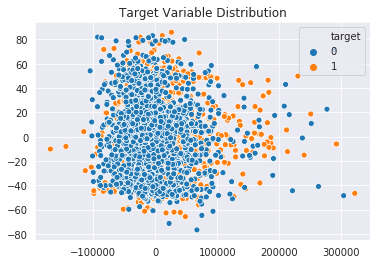

In [8]:
# reduce data to two dimensions
from sklearn.decomposition import PCA
Data_2D = PCA(n_components=2).fit_transform(Data)

sns.scatterplot(Data_2D[:,0], Data_2D[:,1], hue=target)
plt.title("Target Variable Distribution")
plt.show;

### Scale Data

In [9]:
Data_raw = Data.copy()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Data = scaler.fit_transform(Data_raw.drop(['explicit'], axis=1))
Data = pd.DataFrame(Data, columns=Data_raw.drop(['explicit'], axis=1).columns)
Data['explicit'] = Data_raw['explicit']
Data.describe()

,m,oh,know,don,love,like,will,get,go,nan,come,let,time,ve,feel,want,to,cause,wanna,yeah,heart,think,tell,,way,need,away,win,pre,right,fall,night,baby,leave,run,ain,hold,good,look,say,...,big,well,better,touch,body,shine,ask,slow,round,sweet,kid,white,easy,feeling,blow,waste,money,pain,sound,keep,help,chase,city,fine,morning,sing,drop,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,popularity
count,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,...,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000,3502.000000
mean,0.037315,0.007047,0.012586,0.014545,0.011118,0.017476,0.021645,0.014187,0.011268,0.554255,0.011946,0.016826,0.016340,0.014195,0.013992,0.012094,0.010240,0.022898,0.005809,0.007763,0.009784,0.013278,0.018594,0.304112,0.013006,0.011182,0.009841,0.014785,0.043547,0.006737,0.008832,0.009617,0.013357,0.009768,0.006197,0.008118,0.010163,0.011094,0.010007,0.009138,...,0.001831,0.005901,0.002641,0.005226,0.005226,0.002887,0.008614,0.003212,0.005054,0.003141,0.002010,0.003590,0.002776,0.005521,0.002600,0.001098,0.002729,0.004911,0.003034,0.006032,0.003016,0.001609,0.003690,0.003179,0.003950,0.007853,0.007853,0.274668,0.575307,0.344138,0.626233,0.057411,0.482555,0.165017,0.782797,0.717590,0.073013,0.461035,0.739292,0.360708
std,0.097627,0.039844,0.041468,0.045868,0.042948,0.053682,0.069216,0.050649,0.041609,0.497119,0.048287,0.066475,0.055739,0.049993,0.050297,0.051011,0.050535,0.076001,0.033390,0.039968,0.041013,0.053954,0.074283,0.460096,0.046850,0.051206,0.052025,0.067000,0.117967,0.038226,0.043634,0.041824,0.063261,0.039363,0.036510,0.042377,0.051130,0.055365,0.043452,0.041167,...,0.020949,0.048829,0.028321,0.041102,0.044633,0.028826,0.056871,0.028942,0.043683,0.034149,0.022897,0.040887,0.026924,0.043934,0.027767,0.018508,0.026383,0.040686,0.026591,0.044956,0.026530,0.020858,0.034247,0.028259,0.032671,0.061920,0.054563,0.274153,0.132811,0.097215,0.196391,0.187375,0.325282,0.141803,0.105347,0.450236,0.119567,0.183881,0.064019,0.258783
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000

## Clustering

In [0]:
# define dataframes to store results
cluster_desc = []
cluster_score = pd.DataFrame()

# define supervised modeling function
def unsupervised_clf(model, data, target, test_size=0.25, stratify=None):
  """
  """
  #from sklearn.model_selection import train_test_split
  #from sklearn.metrics import silhouette_score, adjusted_rand_score
  
  X_train, X_test, y_train, y_test = train_test_split(
      data, target, test_size=test_size, stratify=stratify, random_state=42)
  
  # silhouette score
  sil_scores = []
  for sample in [X_train, X_test]:
    model.fit(sample)
    labels = model.labels_
    sil_score = silhouette_score(sample, labels, metric='euclidean')
    sil_scores.append(sil_score)
  
  sil_var = np.round(np.var(sil_scores)*100, 4)
  train_sil = np.round(sil_scores[0]*100, 4)
  test_sil = np.round(sil_scores[1]*100, 4)
  print('\nTraining silhouette score:', train_sil)
  print('\nValidation silhouette score:', test_sil)
  print('\nSilhouette score variance:', sil_var)
  
  #rand index
  model.fit(data)
  ARI = np.round(adjusted_rand_score(target, model.labels_), 4)
  print("\nAdjusted rand index:", ARI)
  
  return pd.DataFrame([[train_sil, test_sil, sil_var, ARI]],
                      columns=["train_sil_score", "test_sil_score", "sil_var", "ARI"])

### K-Means

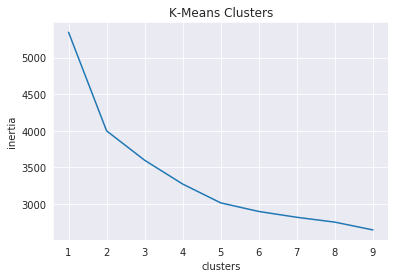

In [11]:
#from sklearn.cluster import KMeans

# Run the Kmeans algorithm and get the index of data points clusters
inertia = []
k_range = list(range(1, 10))

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    inertia.append(kmeans.fit(Data).inertia_)

sns.lineplot(k_range, inertia)
plt.xlabel("clusters")
plt.ylabel("inertia")
plt.title("K-Means Clusters")
plt.show;

In [12]:
kmeans = KMeans(n_clusters=5, max_iter=600, algorithm ='auto', random_state=42)

cluster_desc.append("k-means")

print("Model: {}".format(cluster_desc[-1]))

new_score = unsupervised_clf(model=kmeans,
                             data=Data,
                             target=target,
                             stratify=target)
cluster_score = cluster_score.append(new_score, ignore_index=True)

Model: k-means

Training silhouette score: 24.6766

Validation silhouette score: 24.4803

Silhouette score variance: 0.0001

Adjusted rand index: 0.1716


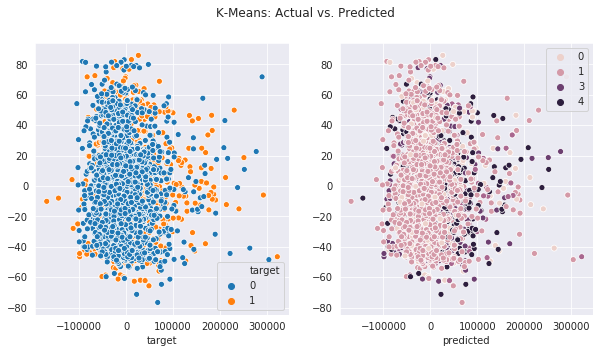

In [13]:
#labels = kmeans.fit(Data).labels_
labels = kmeans.predict(Data)
labels_list = [target, labels]
title_list=["target", "predicted", "K-Means: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Mean Shift

In [14]:
#from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(Data, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth)

cluster_desc.append("mean shift")

print("Model: {}".format(cluster_desc[-1]))

new_score = unsupervised_clf(model=meanshift,
                             data=Data,
                             target=target,
                             stratify=target)
cluster_score = cluster_score.append(new_score, ignore_index=True)

Model: mean shift

Training silhouette score: 16.623

Validation silhouette score: 17.1447

Silhouette score variance: 0.0007

Adjusted rand index: 0.0837


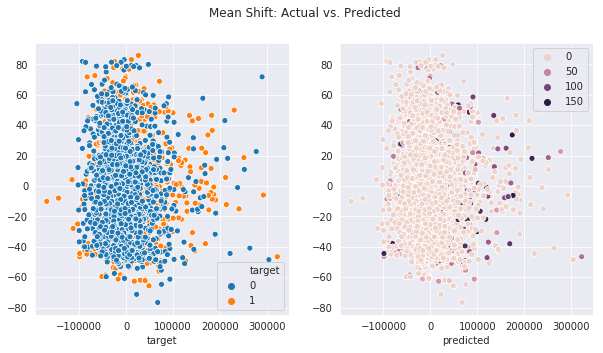

In [15]:
labels = meanshift.fit(Data).labels_
labels_list = [target, labels]
title_list=["target", "predicted", "Mean Shift: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Spectral Clustering

In [16]:
spec = SpectralClustering()

cluster_desc.append("spectral clustering")

print("Model: {}".format(cluster_desc[-1]))

new_score = unsupervised_clf(model=spec,
                             data=Data,
                             target=target,
                             stratify=target)
cluster_score = cluster_score.append(new_score, ignore_index=True)

Model: spectral clustering

Training silhouette score: 15.947

Validation silhouette score: 24.1922

Silhouette score variance: 0.17

Adjusted rand index: 0.1591


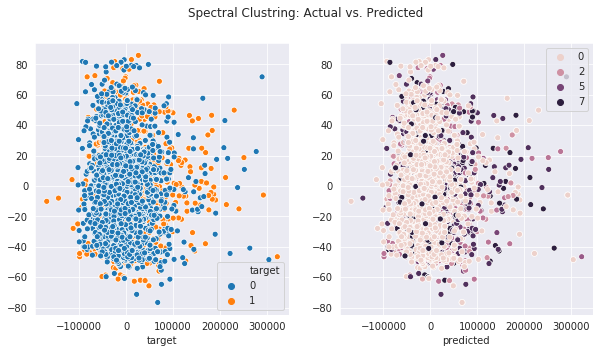

In [17]:
labels = spec.fit(Data).labels_
labels_list = [target, labels]
title_list=["target", "predicted", "Spectral Clustring: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Affinity Propagation

In [18]:
#from sklearn.cluster import AffinityPropagation
aff = AffinityPropagation()
cluster_desc.append("affinity propagation")

print("Model: {}".format(cluster_desc[-1]))

new_score = unsupervised_clf(model=aff,
                             data=Data,
                             target=target,
                             stratify=target)
cluster_score = cluster_score.append(new_score, ignore_index=True)

Model: affinity propagation

Training silhouette score: 7.9699

Validation silhouette score: 11.1752

Silhouette score variance: 0.0257

Adjusted rand index: 0.0118


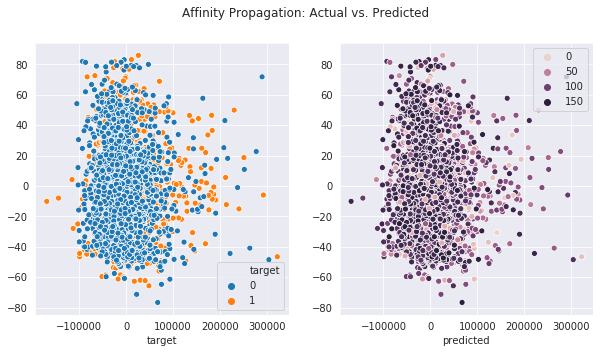

In [19]:
labels = aff.fit(Data).labels_
labels_list = [target, labels]
title_list=["target", "predicted", "Affinity Propagation: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Agglomerative Clustering

In [20]:
#from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering()

cluster_desc.append("agglomerative clustering")

print("Model: {}".format(cluster_desc[-1]))

new_score = unsupervised_clf(model=agg,
                             data=Data,
                             target=target,
                             stratify=target)
cluster_score = cluster_score.append(new_score, ignore_index=True)

Model: agglomerative clustering

Training silhouette score: 27.6237

Validation silhouette score: 25.2543

Silhouette score variance: 0.014

Adjusted rand index: 0.1187


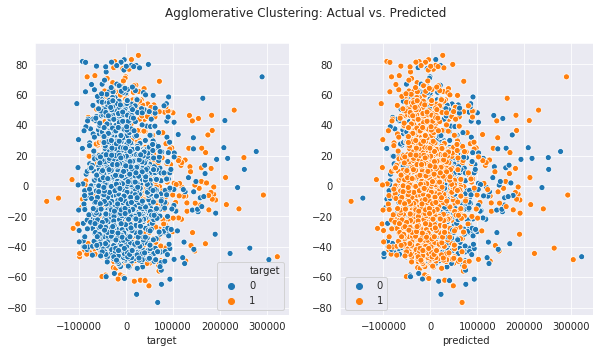

In [21]:
labels = agg.fit(Data).labels_
labels_list = [target, labels]
title_list=["target", "predicted", "Agglomerative Clustering: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### DBSCAN

In [22]:
#from sklearn.cluster import DBSCAN
dbscan = DBSCAN()

cluster_desc.append("DBSCAN")

print("Model: {}".format(cluster_desc[-1]))

new_score = unsupervised_clf(model=dbscan,
                             data=Data,
                             target=target,
                             stratify=target)
cluster_score = cluster_score.append(new_score, ignore_index=True)

Model: DBSCAN

Training silhouette score: 9.8677

Validation silhouette score: 12.11

Silhouette score variance: 0.0126

Adjusted rand index: 0.2235


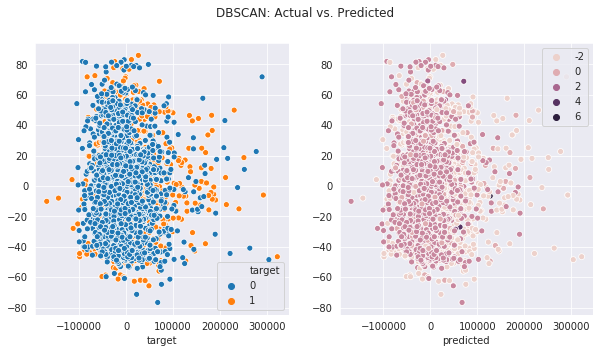

In [23]:
labels = dbscan.fit(Data).labels_
labels_list = [target, labels]
title_list=["target", "predicted", "DBSCAN: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Assessment

In [24]:
cluster_score.describe()

,train_sil_score,test_sil_score,sil_var,ARI
count,6.000000,6.000000,6.000000,6.000000
mean,17.117983,19.059450,0.037183,0.128067
std,7.815024,6.453362,0.065757,0.074216
min,7.969900,11.175200,0.000100,0.011800
25%,11.387525,13.368675,0.003675,0.092450
50%,16.285000,20.668450,0.013300,0.138900
75%,22.663200,24.408275,0.022775,0.168475
max,27.623700,25.254300,0.170000,0.223500


In [25]:
cluster_score = pd.concat([pd.Series(cluster_desc, name="model"), cluster_score], axis=1)
cluster_score.sort_values(by="ARI", ascending=False).head(5)

,model,train_sil_score,test_sil_score,sil_var,ARI
5,DBSCAN,9.8677,12.1100,0.0126,0.2235
0,k-means,24.6766,24.4803,0.0001,0.1716
2,spectral clustering,15.9470,24.1922,0.1700,0.1591
4,agglomerative clustering,27.6237,25.2543,0.0140,0.1187
1,mean shift,16.6230,17.1447,0.0007,0.0837


## Supervised

In [0]:
# define dataframes to store results
super_desc = []
super_score = pd.DataFrame()

# define supervised modeling function
def supervised_clf(model, data, target, test_size=0.25, stratify=None, cv=5):
  """
  """
  #from sklearn.model_selection import train_test_split, cross_val_score
  
  X_train, X_test, y_train, y_test = train_test_split(
      data, target, test_size=test_size, stratify=stratify, random_state=42)
  
  model = model.fit(X_train, y_train)
  train_score = model.score(X_train, y_train)
  test_score = model.score(X_test, y_test)
  print('\nTraining score:', train_score)
  print('\nValidation score:', test_score)
  
  cv_scores = cross_val_score(model, data, target, cv=cv)
  cv_score = np.round(np.mean(cv_scores)*100, 4)
  variance = np.round(np.var(cv_scores)*100, 4)
  print('\nCross validation: {} +/- {}%'.format(cv_score, variance))
  
  return pd.DataFrame([[train_score, test_score, cv_score, variance]],
                      columns=["train_score", "test_score", "cv_score", "variance"])

### Naive Bayes

In [27]:
#from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
super_desc.append("naive bayes")
print("Model: {}".format(super_desc[-1]))

new_score = supervised_clf(model=bayes,
                           data=Data,
                           target=target,
                           stratify=target)
super_score = super_score.append(new_score, ignore_index=True)

Model: naive bayes

Training score: 0.6976389946686976

Validation score: 0.7191780821917808

Cross validation: 66.5397 +/- 0.3492%


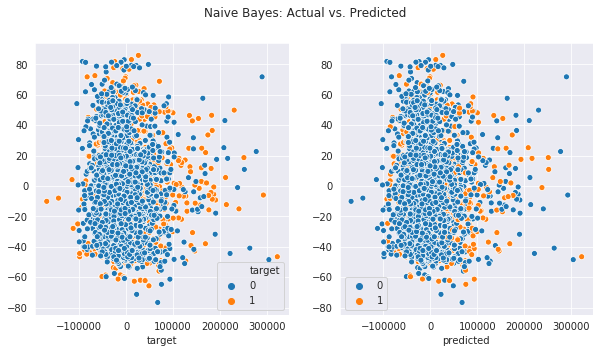

In [28]:
y_pred = bayes.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Naive Bayes: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Support Vector Machines

In [29]:
#from sklearn.svm import SVC
svm = SVC(gamma='scale')
super_desc.append("support vector machines")
print("Model: {}".format(super_desc[-1]))

new_score = supervised_clf(model=svm,
                           data=Data,
                           target=target,
                           stratify=target)
super_score = super_score.append(new_score, ignore_index=True)

Model: support vector machines

Training score: 0.8556740289413557

Validation score: 0.841324200913242

Cross validation: 82.7004 +/- 0.3214%


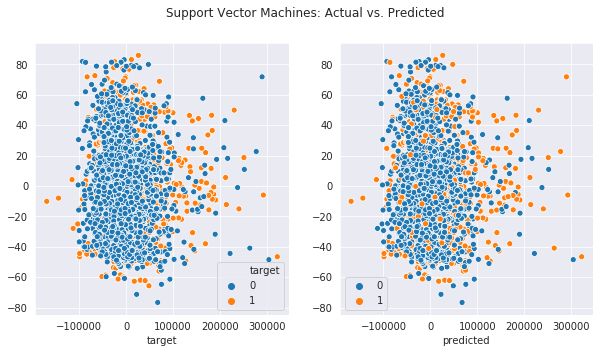

In [30]:
y_pred = svm.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Support Vector Machines: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### SGD Classifier

In [31]:
#from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
super_desc.append("SGD")
print("Model: {}".format(super_desc[-1]))

new_score = supervised_clf(model=sgd,
                           data=Data,
                           target=target,
                           stratify=target)
super_score = super_score.append(new_score, ignore_index=True)

Model: SGD

Training score: 0.8804265041888805

Validation score: 0.8481735159817352

Cross validation: 83.4998 +/- 0.3017%


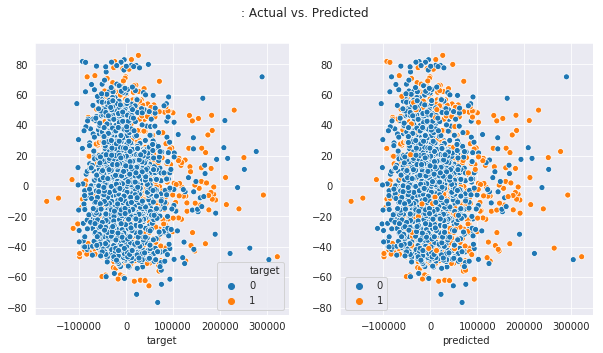

In [32]:
y_pred = sgd.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", ": Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Random Forest

In [33]:
#from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
super_desc.append("random forest")
print("Model: {}".format(super_desc[-1]))

new_score = supervised_clf(model=rfc,
                           data=Data,
                           target=target,
                           stratify=target)
super_score = super_score.append(new_score, ignore_index=True)

Model: random forest

Training score: 0.9996191926884996

Validation score: 0.9018264840182648

Cross validation: 84.5345 +/- 1.2785%


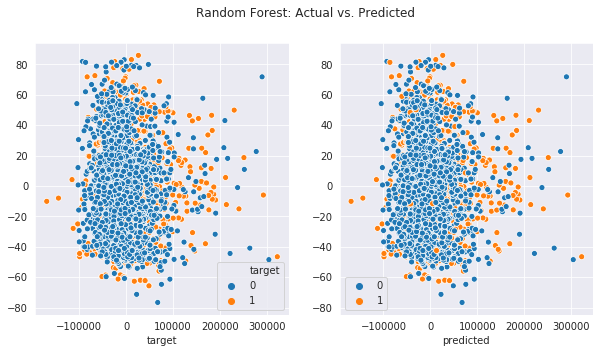

In [34]:
y_pred = rfc.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Random Forest: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Multilayer Processing

In [35]:
#from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
super_desc.append("multilayer processing")
print("Model: {}".format(super_desc[-1]))

new_score = supervised_clf(model=mlp,
                           data=Data,
                           target=target,
                           stratify=target)
super_score = super_score.append(new_score, ignore_index=True)

Model: multilayer processing


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Training score: 0.9329779131759329

Validation score: 0.8481735159817352


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Cross validation: 82.9302 +/- 0.3773%


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


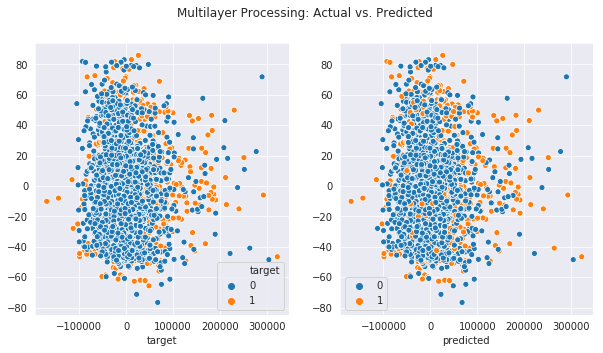

In [36]:
y_pred = mlp.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Multilayer Processing: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Gradient Boosting

In [37]:
#from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.1)
super_desc.append("gradient boosting")
print("Model: {}".format(super_desc[-1]))

new_score = supervised_clf(model=gbc,
                           data=Data,
                           target=target,
                           stratify=target)
super_score = super_score.append(new_score, ignore_index=True)

Model: gradient boosting

Training score: 0.9424980959634425

Validation score: 0.882420091324201

Cross validation: 85.928 +/- 0.4418%


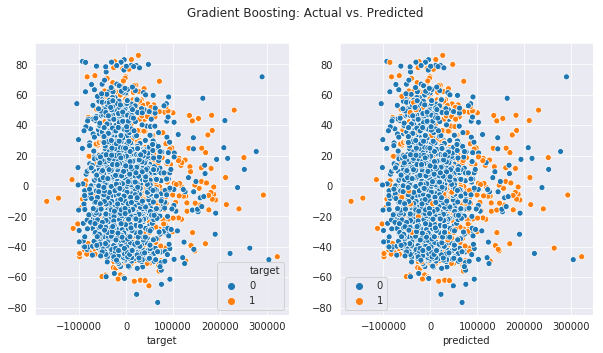

In [38]:
y_pred = gbc.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Gradient Boosting: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

### Assessment

In [39]:
super_score[["cv_score", "variance"]].describe()

,cv_score,variance
count,6.000000,6.000000
mean,81.022100,0.511650
std,7.193626,0.378854
min,66.539700,0.301700
25%,82.757850,0.328350
50%,83.215000,0.363250
75%,84.275825,0.425675
max,85.928000,1.278500


In [40]:
super_score = pd.concat([pd.Series(super_desc, name="model"), super_score], axis=1)
super_score.sort_values(by=["cv_score"], ascending=False).head(5)

,model,train_score,test_score,cv_score,variance
5,gradient boosting,0.942498,0.882420,85.9280,0.4418
3,random forest,0.999619,0.901826,84.5345,1.2785
2,SGD,0.880427,0.848174,83.4998,0.3017
4,multilayer processing,0.932978,0.848174,82.9302,0.3773
1,support vector machines,0.855674,0.841324,82.7004,0.3214


## Model Tuning

In [41]:
#from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [0]:
# learning rate 
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'auto', None]
# Maximum number of levels in tree
max_depths = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depths.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
# boosting
warm_start = [True, False]

# Create the random grid
param_grid = {'learning_rate': learning_rates,
              'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depths,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'warm_start': warm_start}

In [0]:
# split data 
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    Data, target, test_size=0.25, stratify=target, random_state=42)

# sample data for parameter search
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_train, y_train, test_size=0.5, random_state=42, stratify=y_train)

In [76]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rand_search = RandomizedSearchCV(GradientBoostingClassifier(), param_grid,
                                 n_iter=100, cv=3, verbose=2, n_jobs=-1)

rand_search.fit(X_train_sample, y_train_sample)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished


CPU times: user 3.75 s, sys: 93.6 ms, total: 3.84 s
Wall time: 3min 4s


In [77]:
best_params = rand_search.best_params_
best_params

{'learning_rate': 0.05,
 'max_depth': 100,
 'max_features': None,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.5,
 'n_estimators': 400,
 'warm_start': True}

## Final Model

In [0]:
# hard code best parameters
#best_params = {'learning_rate': 0.05,
#               'max_depth': 100,
#               'max_features': None,
#               'min_samples_leaf': 0.1,
#               'min_samples_split': 0.5,
#               'n_estimators': 400,
#               'warm_start': True}

In [79]:
gbc = GradientBoostingClassifier(**best_params)
supervised_clf(gbc, Data, target, stratify=target)


Training score: 0.915079969535415

Validation score: 0.8721461187214612

Cross validation: 85.4702 +/- 0.3136%


,train_score,test_score,cv_score,variance
0,0.91508,0.872146,85.4702,0.3136


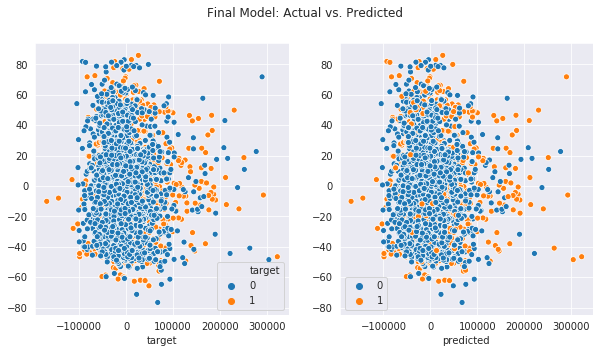

In [72]:
y_pred = mlp.predict(Data)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Final Model: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show;

## Conclusion